In [40]:
import optim, Plots, PyCall, Replica

In [2]:
reload("optim")
reload("Replica")

In [41]:
font = Plots.font("TeX Gyre Heros")
myfonts = Dict(:guidefont=>font,
:xtickfont=>font, :ytickfont=>font, :legendfont=>font);
Plots.pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)

Plots.PyPlotBackend()

Asymptotic approximation
---------

In [78]:
reload("Replica")
npackets=10000
νmin=1.00677
νmax=1.0683018
read_function = nsim -> Replica.read_real(nsim; npackets=npackets, νmin=νmin, νmax=νmax)
n, sums, predict, stddev, skewness, excess_kurtosis = Replica.analyze(250, read_function)
irun=110
println("E[n]=$(mean(n)), n[irun]=$(n[irun])")

Observed: 8.293835096322443 ± 0.6881545641348954
Predicted: 8.18460950641236 ± 1.2320851994247415
E[n]=299.288, n[irun]=291


INFO: Replica 110: 8.205533782683611 vs 8.094375098717025 ± 1.2181416570086083



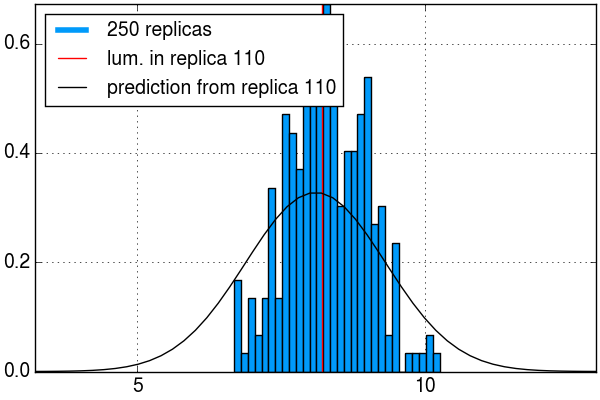

In [61]:
Replica.plotprediction(sums, predict, stddev, irun)


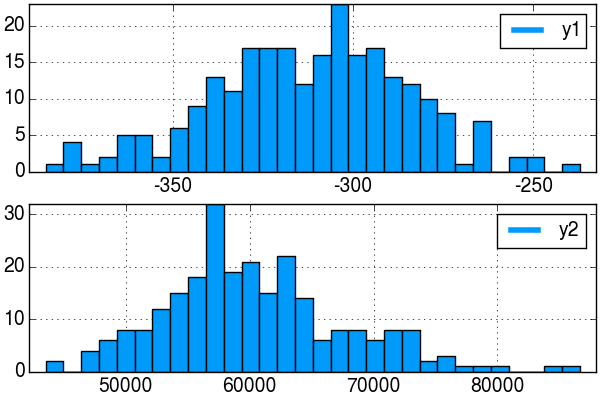

In [79]:
Plots.histogram(skewness, layout=(2,1))
Plots.histogram!(excess_kurtosis, subplot=2, layout=(2,1))

These values seem large, do they make sense?

Gamma model
-----

In [62]:
# define order of linear models
αOrder = 4
βOrder = 2

# read in data and create posterior
dim = αOrder + βOrder
∇res, Hres = optim.allocations(dim)
frame, (P, ∇P!, HP!) = optim.problem(αOrder=αOrder, βOrder=βOrder, run=99, npackets=npackets);

In [63]:
# compute the posterior mode to estimate the evidence
@time maxP, posterior_mode, ret = optim.run_nlopt(frame, P, ∇P!, HP!, αOrder, βOrder, xtol_rel=1e-3)
HP!(posterior_mode, Hres)
evidence = optim.laplace(maxP, Hres)
println("got $maxP at $(posterior_mode) (returned $ret) and evidence $evidence")

  0.793977 seconds (17.95 M allocations: 273.946 MB, 5.76% gc time)
got 20731.62278600134 at [1.59516,-0.734878,0.474981,-0.0417007,57.1369,2.65535] (returned XTOL_REACHED) and evidence 20723.846131775193


 17.973554 seconds (448.23 M allocations: 6.679 GB, 7.65% gc time)
got 207090.19544171615 at [1.59799,-0.279475,0.0137261,0.0925643,56.8278,2.24986] (returned XTOL_REACHED) and evidence 207075.6746506941

In [64]:
# the posterior mean with the normalized posterior
# predict at bin center
# ν, X, N
pm = optim.PosteriorMean((νmax + νmin)/2, sums[irun], convert(Float64, n[irun]))
# pm = optim.PosteriorMean(0.01, 0.5, 6.)
Pmean, ∇Pmean!, HPmean! = optim.targetfactory(frame, αOrder, βOrder, evidence=evidence, pm=pm)
@time maxPmean, mean_mode, ret = optim.run_nlopt(frame, Pmean, ∇Pmean!, HPmean!, αOrder, βOrder,
init=posterior_mode, xtol_rel=1e-3)
println("max of normalized posterior = $maxPmean at $(mean_mode), returned $ret")

  0.625123 seconds (15.35 M allocations: 234.212 MB, 5.16% gc time)
max of normalized posterior = -9.56521500991829 at [1.57535,-0.709234,0.468385,-0.0495369,57.0745,2.61619], returned XTOL_REACHED


 11.617350 seconds (322.92 M allocations: 4.812 GB, 8.23% gc time)
max of normalized posterior = 593.6109048238263 at [1.59822,0.0768632,69.7916,-0.869807], returned XTOL_REACHED (1e-4)


requires the mode from posterior (evidence calculation)

In [65]:
# n, a
nb = optim.NegBinom(n[irun], 0.5)
Pall, ∇Pall!, HPall! = optim.targetfactory(frame, αOrder, βOrder, evidence=evidence, pm=pm, nb=nb)
@time maxPall, mode, ret = optim.run_nlopt(frame, Pall, ∇Pall!, HPall!, αOrder, βOrder,
init=vcat(posterior_mode, 10), xtol_rel=1e-3, nb=nb)
println("max of normalized all posterior = $maxPall at $mode")


  0.794173 seconds (19.43 M allocations: 296.524 MB, 4.59% gc time)
max of normalized all posterior = -534.7146854289114 at [1.59587,-0.749957,0.50244,-0.0396409,57.1162,2.66001,17.4973]


In [66]:
points = collect(linspace(predict[i]-5stddev[irun], predict[i]+5stddev[irun], 20))
results = zeros(points)
# skip X = 0, start at 2
for i in 2:length(points)
    pm.X = points[i]
    results[i] = optim.predict_small(frame, Pmean, ∇Pmean!, HPmean!, pm, αOrder, βOrder, posterior_mode,
    nb, optimize=false)
end

# self-normalize estimates through Simpson's rule
PyCall.@pyimport scipy.integrate as si
norm = si.simps(results, points)
println("norm = $norm")
results /= norm
println(results)


initial N=169
initial N=193
initial N=216
initial N=239
initial N=263
initial N=283
initial N=305
initial N=327
initial N=345
initial N=366
initial N=386
initial N=408
initial N=425
initial N=448
initial N=465
initial N=485
initial N=504
initial N=525
initial N=546
norm = 0.9260090691544827
[0.0,1.88826e-10,1.10192e-6,0.000452352,0.0238608,0.239415,0.614893,0.505547,0.154191,0.0201175,0.00123535,3.88644e-5,6.81267e-7,6.9664e-9,4.40991e-11,1.7885e-13,4.84532e-16,9.01915e-19,1.19755e-21,1.16323e-24]


Output without normalizing gamma distribution to $x \in [0,1]$

    norm = 0.9632725771703211
    [0.0,0.331754,0.712386,1.18703,1.6955,2.17674,2.58467,2.88045,3.05146,3.10053,3.03929,2.88574,2.67116,2.41638,2.1392,1.85987,1.58856,1.3372,1.10664,0.907021,0.733854,0.587862,0.465607,0.364297,0.283832]

Plot all predictions together

μ=6.312778369140037, σ=0.6158533279538095


INFO: Replica 110: 8.205533782683611 vs 8.094375098717025 ± 1.2181416570086083



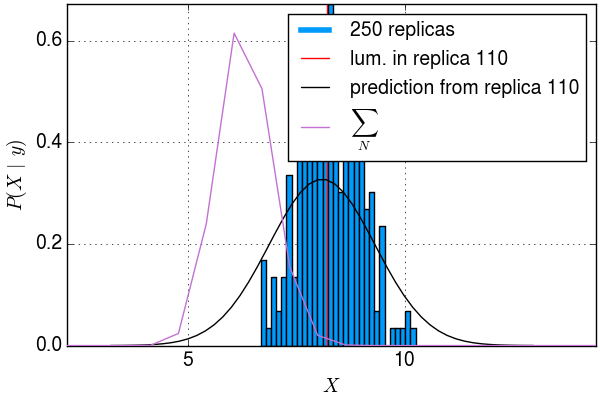

In [70]:
μ = si.simps(results .* points, points)
σ = √(si.simps(results .* (points - μ).^2, points))

println("μ=$μ, σ=$σ")
Replica.plotprediction(sums, predict, stddev, irun)
Plots.plot!(points, results, label=L"\sum_N", xlabel=L"X", ylabel=L"P(X\,|\,y)")

In [10]:
frame[:energies] |> maximum

0.18642974474027474

Min and max $\nu$

In [11]:
frame[:nus][1], frame[:nus][end]

(0.03288078826335864,3.23032919750366)

In [12]:
using Polynomials,LaTeXStrings

In [13]:
αPoly = Poly(posterior_mode[1:αOrder])
Plots.plot(frame[:nus], polyval(αPoly, frame[:nus]), xlabel=L"\nu", ylabel=L"\alpha")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 2 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 28.1037,299.776 28.5976,300.257 31.5158,303.065 31.6779,303.219 33.6433,305.072 33.6844,305.111 33.8723,305.286 34.2265,305.617 34.4529,305.827 35.5336,306.828 
 35.6054,306.894 35.7907,307.065 36.1494,307.395 36.3272,307.558 36.7699,307.963 36.8316,308.019 37.1508,308.31 37.4113,308.547 37.5253,308.65 37.6481,308.762 
 37.7594,308.862 37.7723,308.874 37.8604,308.954 37.9908,309.072 38.1878,309.25 39.3329,310.279 39.7274,310.631 39.7521,310.653 40.0276,310.898 40.133,310.992 
 41.0061,311.765 41.0148,311.773 41.5782,312.269 41.756,312.425 42.1803,312.796 42.5423,313.112 42.8258,313.359 43.0094,313.518 43.0559,313.559 43.2245,313.705 
 43.2705,313.745 43.2814,313.754 43.8696,314.262 43.9701,314.349 44.0157,314.388 44.1073,314.467 44.1992,314.546 44.2973,314.63 44.3866,314.707 44.5365,314.836 
 44.8675,315.119 44.9742,315.21 45.3932,315.567 45.6832,315.814 45.8671,315.969 46.0077,316.089 46.1457,316.205 46.1995,316.251 46.4325,316.447 46.4524,316.464 
 46.838,316.789 46.8917,316.834 46.978,316.906 47.3338,317.205 47.4777,317.325 47.6237,317.447 47.8452,317.632 47.8484,317.634 47.9011,317.678 47.9639,317.731 
 48.1067,317.849 48.1405,317.878 48.2013,317.928 48.2594,317.976 48.3033,318.013 48.5595,318.225 48.6825,318.327 48.7806,318.408 48.8478,318.464 48.8866,318.496 
 49.1889,318.745 49.3529,318.88 49.4072,318.925 49.4286,318.942 49.8017,319.249 49.8522,319.29 49.9659,319.383 49.99,319.403 50.0492,319.451 50.1902,319.566 
 50.3073,319.662 50.6849,319.969 50.6913,319.975 50.7849,320.051 50.8316,320.089 50.8807,320.128 50.9412,320.178 51.0533,320.268 51.1165,320.32 51.2191,320.403 
 51.2614,320.437 51.2623,320.438 51.3948,320.545 51.6416,320.744 51.7085,320.798 51.7153,320.803 51.7611,320.84 51.7628,320.842 51.9349,320.98 52.0284,321.055 
 52.1716,321.17 52.1861,321.182 52.2055,321.198 52.2757,321.254 52.3235,321.292 52.3299,321.297 52.6611,321.562 52.7285,321.616 52.9102,321.761 53.0462,321.869 
 53.0531,321.875 53.1005,321.913 53.1504,321.952 53.2217,322.009 53.2814,322.057 53.327,322.093 53.3851,322.139 53.3901,322.143 53.4621,322.2 53.5801,322.294 
 53.5818,322.295 53.7018,322.39 53.7069,322.394 53.7419,322.422 53.7755,322.448 53.8631,322.518 53.9503,322.587 54.0184,322.64 54.1533,322.747 54.2384,322.814 
 54.2873,322.852 54.4215,322.958 54.5156,323.032 54.6741,323.157 54.6781,323.16 54.9063,323.339 55.1052,323.494 55.1141,323.501 55.1191,323.505 55.153,323.532 
 55.1662,323.542 55.3648,323.697 55.3852,323.713 55.3905,323.717 55.423,323.742 55.4715,323.78 55.5084,323.809 55.6046,323.884 55.7737,324.015 55.7944,324.031 
 55.8194,324.051 55.8212,324.052 55.9167,324.126 55.9571,324.158 55.9879,324.181 56.0663,324.242 56.0993,324.268 56.1877,324.336 56.4019,324.502 56.4318,324.525 
 56.5059,324.582 56.5532,324.619 56.5693,324.631 56.6158,324.667 56.6769,324.714 56.8045,324.812 56.9297,324.909 56.9363,324.914 57.0187,324.977 57.0401,324.994 
 57.0444,324.997 57.1033,325.042 57.1886,325.108 57.2455,325.151 57.2923,325.187 57.3985,325.268 57.4772,325.329 57.478,325.329 57.486,325.335 57.5891,325.414 
 57.7029,325.501 57.7054,325.503 57.7247,325.518 57.9527,325.692 57.9751,325.709 58.0594,325.773 58.1617,325.851 58.2341,325.906 58.2609,325.926 58.2793,325.94 
 58.4117,326.041 58.531,326.131 58.5522,326.147 58.5593,326.152 58.6008,326.184 58.6885,326.25 58.7879,326.325 58.8342,326.36 58.8653,326.384 58.8835,326.398 
 59.0185,326.5 59.0466,326.521 59.2218,326.653 59.2528,326.676 59.4064,326.792 59.4145,326.798 59.4188,326.801 59.5169,326.875 59.521,326.878 59.6083,326.943 
 59.6189,326.951 59.6431,326.969 59.6499,326.974 59.733,327.037 59.9111,327.17 59.9287,327.183 60.0155,327.248 60.112,327.32 60.1595,327.356 60.1684,327.362 
 60.188,327.377 60.1891,327.378 60.1923,327.38 60.3279,327.4

In [14]:
βPoly = Poly(posterior_mode[αOrder+1:αOrder+βOrder])
Plots.plot(frame[:nus], polyval(βPoly, frame[:nus]),  xlabel=L"\nu", ylabel=L"\beta")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 58 
 
 
 60 
 
 
 62 
 
 
 64 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 36.9926,369.674 37.4787,369.356 40.3513,367.477 40.5108,367.373 42.4455,366.107 42.4859,366.08 42.6709,365.959 43.0196,365.731 43.2424,365.586 44.3062,364.89 
 44.3769,364.843 44.5593,364.724 44.9124,364.493 45.0874,364.379 45.5232,364.093 45.5839,364.054 45.898,363.848 46.1545,363.68 46.2668,363.607 46.3876,363.528 
 46.4972,363.456 46.5098,363.448 46.5965,363.391 46.725,363.307 46.9189,363.18 48.0461,362.443 48.4343,362.189 48.4587,362.173 48.7299,361.996 48.8336,361.928 
 49.6931,361.366 49.7016,361.36 50.2562,360.997 50.4312,360.883 50.8489,360.609 51.2053,360.376 51.4842,360.194 51.665,360.076 51.7108,360.046 51.8767,359.937 
 51.922,359.907 51.9328,359.9 52.5117,359.522 52.6107,359.457 52.6556,359.428 52.7457,359.369 52.8362,359.309 52.9327,359.246 53.0207,359.189 53.1682,359.092 
 53.494,358.879 53.599,358.81 54.0115,358.54 54.297,358.354 54.478,358.235 54.6163,358.145 54.7522,358.056 54.8052,358.021 55.0345,357.871 55.0541,357.858 
 55.4337,357.61 55.4866,357.576 55.5715,357.52 55.9217,357.291 56.0633,357.198 56.2071,357.104 56.4251,356.962 56.4283,356.96 56.4801,356.926 56.542,356.885 
 56.6825,356.793 56.7158,356.771 56.7757,356.732 56.8328,356.695 56.876,356.667 57.1283,356.502 57.2494,356.422 57.3459,356.359 57.412,356.316 57.4502,356.291 
 57.7478,356.096 57.9092,355.991 57.9626,355.956 57.9838,355.942 58.351,355.702 58.4007,355.669 58.5127,355.596 58.5364,355.58 58.5946,355.542 58.7334,355.452 
 58.8487,355.376 59.2204,355.133 59.2267,355.129 59.3188,355.069 59.3648,355.038 59.4132,355.007 59.4727,354.968 59.583,354.896 59.6453,354.855 59.7462,354.789 
 59.7878,354.762 59.7888,354.761 59.9192,354.676 60.1621,354.517 60.228,354.474 60.2346,354.469 60.2797,354.44 60.2815,354.439 60.4508,354.328 60.5428,354.268 
 60.6838,354.176 60.6981,354.166 60.7172,354.154 60.7863,354.109 60.8333,354.078 60.8396,354.074 61.1656,353.86 61.232,353.817 61.4109,353.7 61.5447,353.612 
 61.5515,353.608 61.5981,353.577 61.6473,353.545 61.7174,353.499 61.7762,353.461 61.8211,353.432 61.8783,353.394 61.8832,353.391 61.9542,353.345 62.0703,353.269 
 62.072,353.267 62.1901,353.19 62.1951,353.187 62.2296,353.164 62.2627,353.143 62.3488,353.086 62.4347,353.03 62.5017,352.986 62.6345,352.899 62.7182,352.845 
 62.7664,352.813 62.8985,352.727 62.9912,352.666 63.1472,352.564 63.1511,352.561 63.3757,352.415 63.5715,352.286 63.5802,352.281 63.5852,352.278 63.6186,352.256 
 63.6316,352.247 63.827,352.119 63.8471,352.106 63.8523,352.103 63.8843,352.082 63.9321,352.051 63.9684,352.027 64.0631,351.965 64.2296,351.856 64.2499,351.843 
 64.2746,351.827 64.2763,351.825 64.3703,351.764 64.4101,351.738 64.4404,351.718 64.5175,351.668 64.55,351.646 64.6371,351.589 64.8479,351.452 64.8773,351.432 
 64.9502,351.385 64.9968,351.354 65.0127,351.344 65.0584,351.314 65.1186,351.274 65.2442,351.192 65.3674,351.112 65.374,351.107 65.4551,351.054 65.4761,351.04 
 65.4803,351.038 65.5383,351 65.6223,350.945 65.6783,350.908 65.7243,350.878 65.8289,350.81 65.9064,350.759 65.9071,350.759 65.915,350.753 66.0166,350.687 
 66.1286,350.614 66.131,350.612 66.15,350.6 66.3745,350.453 66.3965,350.438 66.4794,350.384 66.5802,350.318 66.6515,350.272 66.6778,350.254 66.6959,350.243 
 66.8263,350.157 66.9437,350.08 66.9646,350.067 66.9715,350.062 67.0124,350.036 67.0987,349.979 67.1965,349.915 67.2421,349.885 67.2728,349.865 67.2906,349.853 
 67.4236,349.766 67.4512,349.748 67.6237,349.636 67.6542,349.616 67.8054,349.517 67.8133,349.512 67.8176,349.509 67.9142,349.446 67.9181,349.443 68.0042,349.387 
 68.0146,349.38 68.0384,349.364 68.0451,349.36 68.1269,349.306 68.3022,349.192 68.3196,349.18 68.4049,349.125 68.4999,349.062 68.5467,349.032 68.5555,349.026 
 68.5747,349.013 68.5758,349.013 68.

In [15]:
Plots.histogram(frame[:nus])

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 0 
 
 
 200 
 
 
 400 
 
 
 600 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 y1

In [17]:
Plots.histogram(frame[:energies])

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.00 
 
 
 0.05 
 
 
 0.10 
 
 
 0.15 
 
 
 0 
 
 
 500 
 
 
 1000 
 
 
 1500 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 y1